In [14]:
import numpy as np
import pandas as pd
import pymystem3
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maksimkoltugin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [87]:
train_df = pd.read_excel('Data/train_data_exam_1.xlsx')
test_df = pd.read_excel('Data/test_data_exam_1.xlsx')

# deleting nan and rows containing non-string value at 'original_data'
train_df = train_df.dropna()
train_df = train_df[pd.to_numeric(train_df['original_data'], errors='coerce').isna()].reset_index(drop=True)

test_df = test_df.dropna()
test_df = test_df[pd.to_numeric(test_df['original_data'], errors='coerce').isna()].reset_index(drop=True)

In [88]:
X_train, y_train = train_df['original_data'], train_df['score']
X_test, y_test = test_df['original_data'], test_df['score']

In [89]:
m = pymystem3.Mystem()


def lemmatize(X):
    data = []
    for s in tqdm(X):
        s = re.sub(r"[,.?“/!@#$1234567890#—_ツ►๑۩۞۩•*”˜˜”*°°*`)(]", ' ', s)
        s = m.lemmatize(s)
        s = ''.join(s)
        data.append(s)
    return data

In [90]:
lem_X_train = lemmatize(X_train)
lem_X_test = lemmatize(X_test)

100%|██████████| 8020/8020 [00:36<00:00, 218.16it/s]


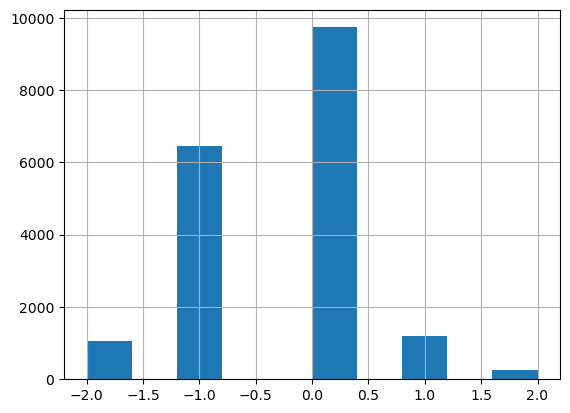

In [96]:
train_df = pd.DataFrame(data=lem_X_train)
train_df = pd.concat([train_df, y_train], axis=1)

train_df['score'].hist()
plt.show()

strong_negative = train_df[train_df['score'] == -2]
negative = train_df[train_df['score'] == -1]
neutral = train_df[train_df['score'] == 0]
positive = train_df[train_df['score'] == 1]
strong_positive = train_df[train_df['score'] == 2]

n = neutral.shape[0]

strong_negative = resample(strong_negative, replace=True, n_samples=n, random_state=0)
negative = resample(negative, replace=True, n_samples=n, random_state=0)
neutral = resample(neutral, replace=True, n_samples=n, random_state=0)
positive = resample(positive, replace=True, n_samples=n, random_state=0)
strong_positive = resample(strong_positive, replace=True, n_samples=n, random_state=0)

train_df = pd.concat([strong_negative, negative, neutral, positive, strong_positive])
lem_X_train, y_train = train_df[0], train_df['score']

In [97]:
words = stopwords.words("russian")
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), stop_words=words, max_df=1., min_df=0.002)

X_train = tfidf_vectorizer.fit_transform(lem_X_train).toarray()
train_features = tfidf_vectorizer.get_feature_names_out()

X_test = tfidf_vectorizer.fit_transform(lem_X_test).toarray()
test_features = tfidf_vectorizer.get_feature_names_out()

In [100]:
test_features.size

(48685, 5779)

In [101]:
def prepare_test_data(train_features, test_features, X_test):
    dct = {word: idx for idx, word in enumerate(train_features)}
    prepared_X_test = np.zeros((X_test.shape[0], train_features.size))

    for i, feature in enumerate(test_features):
        if feature in dct:
            prepared_X_test[:, dct[feature]] = X_test[:, i]

    return prepared_X_test


X_test = prepare_test_data(train_features, test_features, X_test)

In [102]:
np.save('Data/X_train', X_train)
np.save('Data/y_train', y_train)
np.save('Data/X_test', X_test)
np.save('Data/y_test', y_test)